# Nếu mỗi tháng đầu tư 5 triệu Việt Nam Đồng từ 01-01-2015 đến 01-01-2025, loại hình thức đầu tư nào sẽ giúp tổng giá trị tài sản tăng cao nhất vào cuối khoảng thời gian?

## So sánh 3 loại hình thức đầu tư bao gồm: **vàng**, **chứng chỉ quỹ**, **gửi tiết kiệm**

Tải các thư viện cần thiết

In [63]:
%pip install pandas numpy matplotlib vnstock yfinance

Note: you may need to restart the kernel to use updated packages.


`import` các thứ viện cần thiết

In [64]:
import pandas as pd
import numpy as np
from vnstock import Fund
import yfinance as yf
import math
import matplotlib.pyplot as plt

Tạo `DataFrame` gốc, nơi sẽ lưu trữ tất cả dữ liệu

In [65]:
monthly_invest = 5_000_000
startDate = '2015-01-01'
endDate = '2025-01-01'
data = pd.DataFrame(pd.date_range(
    start=startDate,
    end = endDate,
    freq='ME'
),columns=['date']).set_index('date')
data['month'] = range(1,len(data)+1)
data.head(5)


,month
date,
2015-01-31,1
2015-02-28,2
2015-03-31,3
2015-04-30,4
2015-05-31,5


Cột `initialCapital` thể hiện số tiền đã đầu tư tính tới thời điểm đó

In [66]:
data['initialCapital'] = data['month'] * monthly_invest
data.head(5)

,month,initialCapital
date,,
2015-01-31,1,5000000
2015-02-28,2,10000000
2015-03-31,3,15000000
2015-04-30,4,20000000
2015-05-31,5,25000000


Tải các file dữ liệu cần thiết cho quá trình phân tích từ `vnstock`, `yfinance`

In [67]:
fund = Fund()
DCDS = fund.details.nav_report('DCDS')
DCDS.to_csv('DCDS.csv',index=False)

# ===============================
# 1. PARAMETERS
# ===============================




# ===============================
# 2. DOWNLOAD GOLD PRICE (USD / OZ)
# ===============================
gold = yf.download(
    "GC=F",
    start=startDate,
    auto_adjust=True,
    progress=False
)
gold.columns = gold.columns.droplevel(1)
gold.to_csv('GOLD.csv',index=True)

# ===============================
# 3. DOWNLOAD USD/VND EXCHANGE RATE
# ===============================
usd = yf.download(
    "VND=X",
    start=startDate,
    auto_adjust=True,
    progress=False
)
usd.columns = usd.columns.droplevel(1)
usd.to_csv('USD.csv',index=True)


silver = yf.download(
    "SI=F",
    start=startDate,
    auto_adjust=True,
    progress=False
)
silver.columns = silver.columns.droplevel(1)
silver.to_csv('SILVER.csv',index=True)

2025-12-28 15:03:08 - vnstock.explorer.fmarket.fund - INFO - Total number of funds currently listed on Fmarket: 61
2025-12-28 15:03:08 - vnstock.explorer.fmarket.fund - INFO - Retrieving data for DCDS


## Chứng chỉ quỹ

Chứng chỉ quỹ là một loại giấy tờ xác nhận quyền sở hữu của nhà đầu tư đối với một phần tài sản của quỹ đầu tư. Nói cách khác, khi bạn mua chứng chỉ quỹ, bạn đang góp vốn vào quỹ đó, và quỹ sẽ dùng số tiền này để đầu tư vào cổ phiếu, trái phiếu, bất động sản hoặc các công cụ tài chính khác tùy theo mục tiêu của quỹ.

### Thu thập dữ liệu
Thu thập dữ liệu giá của chứng chỉ quỹ (đại diện ở đây là **DCDS (Quỹ Đầu Tư Chứng Khoán Năng Động DC)**)

In [68]:
DCDS = pd.read_csv('DCDS.csv',index_col='date')
DCDS.index = pd.to_datetime(DCDS.index)
DCDS.head()

,nav_per_unit,short_name
date,,
2004-05-20,10000.00,DCDS
2004-05-31,10000.00,DCDS
2004-06-30,10099.00,DCDS
2004-07-31,10040.42,DCDS
2004-08-31,10021.00,DCDS


### Làm sạch dữ liệu

Đổi tên cột `nav_per_unit` để dễ hiểu hơn thành `price`, sau đó bỏ cột `short_name` vì không cần thiết. Để đảm bảo thứ tự giá được sắp xếp đúng, sử dụng `.sort_index()` với **index** là thời gian đã được biến đổi thành dạng có thể so sánh được.

In [69]:
DCDS.rename(columns={'nav_per_unit':'price'},inplace=True)
DCDS.drop('short_name',axis=1,inplace=True)
DCDS = DCDS.sort_index()
DCDS.head(5)


,price
date,
2004-05-20,10000.00
2004-05-31,10000.00
2004-06-30,10099.00
2004-07-31,10040.42
2004-08-31,10021.00


Vì dữ liệu gồm nhiều mức giá trong nhiều ngày của một tháng, ta nhóm hàng lại và chỉ lấy giá cuối cùng của tháng đó, sử dụng `.resample('MS).first()`. Sau đó, lọc các giá trị trong khoảng thời gian xét *(31-01-2015 đến 31-01-2025)*, sử dụng `.loc[]`. Ta sẽ thay thế các dữ liệu giá bị thiếu (nếu có) bằng dữ liệu giá gần nhất trước nó không bị thiếu. 

In [70]:
DCDS = (DCDS
        .resample('ME')
        .last().round(2)
)
DCDS = DCDS.loc[(DCDS.index >= startDate) & (DCDS.index<= endDate)]
DCDS = DCDS.join(data['month'],how='right')
DCDS['price'] = DCDS['price'].ffill().bfill()
DCDS.head(5)


,price,month
date,,
2015-01-31,21342.54,1
2015-02-28,21706.60,2
2015-03-31,20737.23,3
2015-04-30,20988.33,4
2015-05-31,21496.63,5


### Xử lí dữ liệu

Tính số lượng đơn vị **chứng chỉ quỹ** mỗi tháng mua được, cột `'QtyThisMonth'` sẽ thể hiện số lượng đơn vị mua được. Quỹ DCDS cho phép mua với số lượng có 2 số sau dấu thập phân, vì vậy số lượng sẽ được tính tới 2 số thập phân, phần còn lại sẽ được lưu lại để cộng vào tháng sau. sau đó tính tổng số lượng **chứng chỉ quỹ** (cột `TotalQty`) sở hữu và giá trị của khoản đầu tư(cột `PortfolioValue`).

In [71]:

DCDS['QtyThisMonth'] = 0.0
DCDS['remain'] = 0.0
for i in range(len(DCDS)):
    if (i == 0):
        budget = monthly_invest
    else:
        budget = monthly_invest + DCDS.loc[DCDS.index[i-1],'remain']
    DCDS.loc[DCDS.index[i],'QtyThisMonth'] = math.floor(budget * 100  / DCDS.loc[DCDS.index[i],'price']) /100
    DCDS.loc[DCDS.index[i],'remain'] = budget - DCDS.loc[DCDS.index[i],'QtyThisMonth']* DCDS.loc[DCDS.index[i],'price']

DCDS['TotalQty'] = DCDS['QtyThisMonth'].cumsum()
DCDS['PortfolioValue'] = DCDS['TotalQty'] * DCDS['price'] + DCDS['remain']
DCDS.head(5)

,price,month,QtyThisMonth,remain,TotalQty,PortfolioValue
date,,,,,,
2015-01-31,21342.54,1,234.27,83.1542,234.27,5.000000e+06
2015-02-28,21706.60,2,230.34,184.9102,464.61,1.008529e+07
2015-03-31,20737.23,3,241.12,24.0126,705.73,1.463491e+07
2015-04-30,20988.33,4,238.22,184.0400,943.95,1.981212e+07
2015-05-31,21496.63,5,232.60,67.9020,1176.55,2.529193e+07


## Ngân hàng

Tính giá trị của khoản đầu tư theo từng tháng nếu gửi ngân hàng với lãi suất `5%/năm`

In [72]:
anual_interest = 5/100
yearly_save = monthly_invest * 12
Bank =pd.DataFrame(pd.date_range(start=startDate,end=endDate,freq='ME'),columns=['date']).set_index('date')
Bank[['month','PortfolioValue']] = data[['month','initialCapital']].copy()
Bank['PortfolioValue'] = Bank['PortfolioValue'].astype('float')
for i in range(len(Bank)):
    if (i<12):
        continue
    Bank.loc[Bank.index[i],'PortfolioValue'] = Bank.loc[Bank.index[i-12],'PortfolioValue'] * (1+anual_interest) + yearly_save
Bank['PortfolioValue']=Bank['PortfolioValue'].round(2)
Bank.head(5)



,month,PortfolioValue
date,,
2015-01-31,1,5000000.0
2015-02-28,2,10000000.0
2015-03-31,3,15000000.0
2015-04-30,4,20000000.0
2015-05-31,5,25000000.0


## Vàng

### Thu thập dữ liệu

Thu thập giá vàng theo **USD/Ounce** và **USD/VND** từ `yfinance`

In [73]:
USDVND_MIN_VALID = 10000  # USD/VND has never been below this since 2000
gramPerOz = 31.1035
chiPerGram = 1/37.5 * 10
chiPerOz = gramPerOz * chiPerGram

gold = pd.read_csv('GOLD.csv',header=0,index_col='Date')
gold.index = pd.to_datetime(gold.index)
gold.head(5)


,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,1186.000000,1194.500000,1169.500000,1184.000000,138
2015-01-05,1203.900024,1206.900024,1180.099976,1180.300049,470
2015-01-06,1219.300049,1220.000000,1203.500000,1203.500000,97
2015-01-07,1210.599976,1219.199951,1210.599976,1219.199951,29
2015-01-08,1208.400024,1215.699951,1206.300049,1207.000000,92


In [74]:
usd = pd.read_csv('USD.csv',header= 0,index_col = 'Date')
usd.index = pd.to_datetime(usd.index)
usd.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-01-01,21375.0,21375.0,21156.0,21157.0,0
2015-01-02,21063.0,21214.0,21063.0,21214.0,0
2015-01-05,21046.0,21375.0,21046.0,21219.0,0
2015-01-06,21097.0,21390.0,20987.0,20987.0,0
2015-01-07,21083.0,21415.0,21083.0,21135.0,0


### Làm sạch dữ liệu

Nhóm dữ liệu theo tháng. Sau đó nếu tháng nào chưa có dữ liệu thì sẽ lấy dữ liệu trước đó gần nhất không bị thiếu

In [75]:
gold = gold.resample('ME').last().join(data['month'],how='right').ffill().bfill()
gold.drop(columns=['High','Low','Open','Volume'],axis=1,inplace=True)
gold = gold.loc[(gold.index >= startDate) & (gold.index <= endDate)]
gold.rename(columns={'Close':'USD/Once'},inplace=True)
gold.head(5)

,USD/Once,month
date,,
2015-01-31,1278.500000,1
2015-02-28,1212.599976,2
2015-03-31,1183.099976,3
2015-04-30,1182.400024,4
2015-05-31,1189.400024,5


In [76]:

usd = usd.resample('ME').last()
usd.loc[usd['Close']<USDVND_MIN_VALID,'Close'] = pd.NA
usd =usd.join(data['month'],how='right')
usd['Close'] = usd['Close'].ffill()
usd.drop(columns=['High','Low','Open','Volume'],axis=1,inplace=True)
usd = usd.loc[(usd.index >= startDate) & (usd.index <= endDate)]
usd.head(5)

,Close,month
date,,
2015-01-31,21074.0,1
2015-02-28,20984.0,2
2015-03-31,21186.0,3
2015-04-30,21575.0,4
2015-05-31,21785.0,5


### Xử lí dữ liệu
Vì vàng không thể mua lẻ mà nhỏ nhất là theo chỉ nên đơn vị sẽ là lượng.

In [77]:
gold['vnd/chi'] = gold['USD/Once'] *usd['Close']/ chiPerOz
gold['ThisMonthQty'] = 0
gold['remain'] = 0.0

for i in range(len(gold)):
    if (i == 0):
        budget = monthly_invest
    else:
        budget = monthly_invest + gold.loc[gold.index[i-1],'remain']
    gold.loc[gold.index[i],'ThisMonthQty'] = math.floor(budget / gold.loc[gold.index[i],'vnd/chi']) 
    gold.loc[gold.index[i],'remain'] = budget - gold.loc[gold.index[i],'ThisMonthQty'] * gold.loc[gold.index[i], 'vnd/chi']
gold['TotalQty'] = gold['ThisMonthQty'].cumsum()
gold['PortfolioValue'] = np.floor((gold['remain'] + gold['vnd/chi'] * gold['TotalQty'])*100)//100
gold.head(5)

,USD/Once,month,vnd/chi,ThisMonthQty,remain,TotalQty,PortfolioValue
date,,,,,,,
2015-01-31,1278.500000,1,3.248402e+06,1,1.751598e+06,1,5000000.0
2015-02-28,1212.599976,2,3.067806e+06,2,6.159872e+05,3,9819404.0
2015-03-31,1183.099976,3,3.021986e+06,1,2.594001e+06,4,14681944.0
2015-04-30,1182.400024,4,3.075652e+06,2,1.442697e+06,6,19896610.0
2015-05-31,1189.400024,5,3.123975e+06,2,1.947473e+05,8,25186545.0


## Bạc

### Thu thập dữ liệu

Thu thập dữ liệu giá bạc **USD/Once** từ `yfinance`

In [78]:
silver = pd.read_csv('SILVER.csv',header = 0, index_col = 'Date')
silver.index = pd.to_datetime(silver.index)
silver.head(5)

,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,15.734000,15.815000,15.535000,15.790000,13
2015-01-05,16.179001,16.179001,16.179001,16.179001,0
2015-01-06,16.603001,16.603001,16.603001,16.603001,2
2015-01-07,16.510000,16.549999,16.480000,16.480000,9
2015-01-08,16.351000,16.351000,16.351000,16.351000,0


### Làm sạch dữ liệu

Nhóm dữ liệu theo tháng. Sau đó xóa các cột không cần thiêt. Đổi tên cột `close` thành `USD/Oz` để tăng tính đọc hiểu. Cuối cùng kết nối hai bảng với nhau để đảm bảo **bảng dữ liệu của bạc** có cùng số lượng tháng với **bảng dữ liệu chính**

In [79]:
silver = silver.rename(columns = {'Close':'USD/Oz'}).resample('ME').last()

silver.drop(columns=['High','Low','Open','Volume'],axis = 1,inplace = True)
silver = silver.join(data['month'],how = 'right').ffill().bfill()
silver = silver.loc[(silver.index >= startDate) & (silver.index <= endDate)]
silver.head(5)



,USD/Oz,month
date,,
2015-01-31,17.191999,1
2015-02-28,16.513000,2
2015-03-31,16.580999,3
2015-04-30,16.124001,4
2015-05-31,16.684000,5


### Xử lí dữ liệu

In [80]:
silver['VND/gram'] = np.floor(silver['USD/Oz'] * usd['Close']/gramPerOz*100)/100
silver['ThisMonthQty'] = 0
silver['remain'] = 0.0
indices = silver.index
for i in range(len(silver)):
    if i == 0: 
        budget = monthly_invest
    else:
        budget = monthly_invest + silver.loc[indices[i-1],'remain']


    silver.loc[indices[i],'QtyThisMonth'] = math.floor(budget / silver.loc[indices[i],'VND/gram'])
    silver.loc[indices[i],'remain'] = budget - silver.loc[indices[i],'QtyThisMonth'] * silver.loc[indices[i],'VND/gram']

silver['TotalQty'] = silver['QtyThisMonth'].cumsum()
silver['PortfolioValue'] = silver['remain'] + silver['TotalQty'] * silver['VND/gram']
silver.head(5)

,USD/Oz,month,VND/gram,ThisMonthQty,remain,QtyThisMonth,TotalQty,PortfolioValue
date,,,,,,,,
2015-01-31,17.191999,1,11648.34,0,2862.14,429.0,429.0,5000000.00
2015-02-28,16.513000,2,11140.50,0,777.64,449.0,878.0,9782136.64
2015-03-31,16.580999,3,11294.06,0,8803.12,442.0,1320.0,14916962.32
2015-04-30,16.124001,4,11184.44,0,9358.44,447.0,1767.0,19772263.92
2015-05-31,16.684000,5,11685.53,0,7951.60,428.0,2195.0,25657689.95


Kiểm tra các khoản đầu tư có tổng số lượng tháng bằng nhau, để khi ghép không xảy ra lỗi

In [81]:
print(Bank.shape,DCDS.shape,gold.shape,silver.shape)

(120, 2) (120, 6) (120, 7) (120, 8)


Ghép các cột từ các bảng giá trị khác vào **bảng giá trị chính**

In [82]:
data['DCDS'] = DCDS['PortfolioValue']
data['Bank'] = Bank['PortfolioValue']
data['Gold'] = gold['PortfolioValue']
data['Silver'] = silver['PortfolioValue']

Vẽ biểu đồ để trực quan hóa các khoản đầu tư giúp dễ so sánh

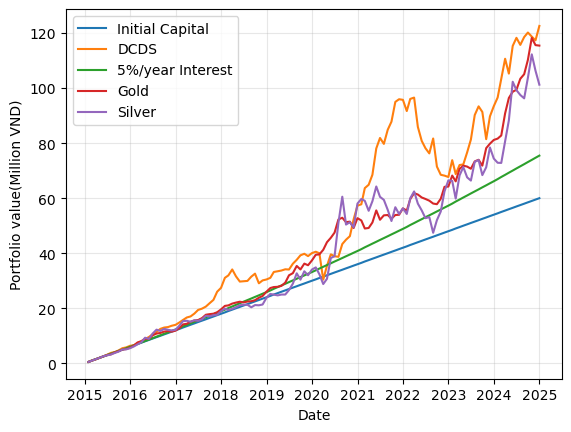

In [83]:
plt.plot(data.index, data['initialCapital']/1_000_0000,label = 'Initial Capital')
plt.plot(data.index,data['DCDS']/1_000_0000, label = 'DCDS')
plt.plot(data.index, data['Bank']/1_000_0000, label = '5%/year Interest')
plt.plot(data.index,data['Gold']/1_000_0000,label='Gold')
plt.plot(data.index,data['Silver']/1_000_0000, label = 'Silver')
plt.xlabel('Date')
plt.ylabel('Portfolio value(Million VND)')
plt.grid(alpha=0.3)

plt.legend()
plt.show()



Từ đây, ta thấy được **chứng chỉ quỹ (DCDS)** sẽ đứng đầu